# IMPORT PACKAGE

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import cv2 as cv
from skimage import feature

# LOAD DATASET

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
class_citra = ['Beras Arborio', 'Beras Basmati']
citra_direct = "../content/drive/My Drive/Dataset/Dataset Beras/"
size_citra = 256

data_citra, label_citra = [],[]
for label in class_citra:
  path = os.path.join(citra_direct, label)
  class_num = class_citra.index(label)  
  for img in os.listdir(path):
    gabung = os.path.join(path, img)
    print(gabung)
    try:
      img_arr = cv.imread(gabung, 0)

      resized_arr = cv.resize(img_arr, (size_citra, size_citra))

      cropped_image = resized_arr[40:250, 30:250]

      #Remove Noise
      median3_3 = cv.medianBlur(cropped_image, ksize = 3)

      ret, mask = cv.threshold(median3_3, 0, 255, cv.THRESH_OTSU + cv.THRESH_BINARY) 

      data_citra.append(mask)
      label_citra.append(class_num)

    except Exception as e:
      print(e)

../content/drive/My Drive/Dataset/Dataset Beras/Beras Arborio/Arborio (1).jpg
../content/drive/My Drive/Dataset/Dataset Beras/Beras Arborio/Arborio (100).jpg
../content/drive/My Drive/Dataset/Dataset Beras/Beras Arborio/Arborio (10).jpg
../content/drive/My Drive/Dataset/Dataset Beras/Beras Arborio/Arborio (101).jpg
../content/drive/My Drive/Dataset/Dataset Beras/Beras Arborio/Arborio (1000).jpg
../content/drive/My Drive/Dataset/Dataset Beras/Beras Arborio/Arborio (115).jpg
../content/drive/My Drive/Dataset/Dataset Beras/Beras Arborio/Arborio (103).jpg
../content/drive/My Drive/Dataset/Dataset Beras/Beras Arborio/Arborio (102).jpg
../content/drive/My Drive/Dataset/Dataset Beras/Beras Arborio/Arborio (105).jpg
../content/drive/My Drive/Dataset/Dataset Beras/Beras Arborio/Arborio (104).jpg
../content/drive/My Drive/Dataset/Dataset Beras/Beras Arborio/Arborio (107).jpg
../content/drive/My Drive/Dataset/Dataset Beras/Beras Arborio/Arborio (109).jpg
../content/drive/My Drive/Dataset/Dataset 

In [ ]:
len(data_citra)

2000

# FEATURE EXTRACTION USING LBP

In [ ]:
def lbpFeatures(citra, radius, sampling_of_pixel):
  if(len(citra.shape) > 2):
    citra = citra.astype(float)
    citra = cv.cvtColor(citra, cv.COLOR_BGR2GRAY)

  citra = citra.astype(np.uint8)

  i_min = np.min(citra)
  i_max = np.max(citra)

  if(i_max - i_min > 0):
    citra = (citra - i_min)/(i_max - i_min)
  
  lbp = feature.local_binary_pattern(citra, sampling_of_pixel, radius, method="uniform")

  (hist, _) = np.histogram(lbp.ravel(), bins = np.arange(0, sampling_of_pixel + 3), range = (0, sampling_of_pixel + 2))

  hist = hist.astype(float)
  hist /= (hist.sum() + 1e-6)

  return hist

# APPLYING TO METHOD LBP FEATURES

In [ ]:
fitur_citra = []
for citra in data_citra:
  fitur = lbpFeatures(citra, 2, 8)
  fitur_citra.append(fitur)

In [ ]:
label_df = pd.DataFrame(label_citra, columns=['Label'])

In [ ]:
citra_df = pd.DataFrame(fitur_citra).assign(label = label_df)

In [ ]:
citra_df.to_csv('data_projek_pcd.csv', index = False)

In [ ]:
kelas0 = data_citra[1]
kelas1 = data_citra[1900]

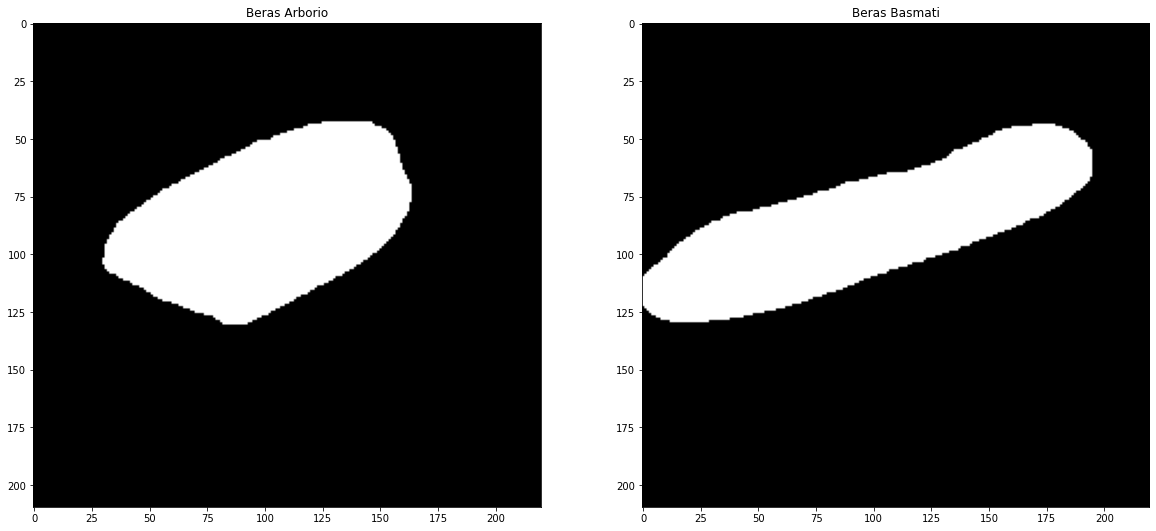

In [ ]:
citra_data = [kelas0, kelas1]
teks_data = ["Beras Arborio","Beras Basmati"]

figure = plt.figure(figsize = (20, 20))
next = 1

for i in range(0, len(citra_data)):
    tampilan = figure.add_subplot(1, 2, next)
    tampilan.imshow(citra_data[i], cmap='gray')
    tampilan.title.set_text(teks_data[i])
    next += 1

plt.show()

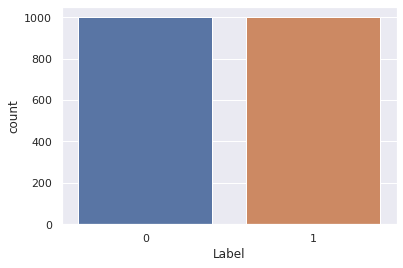

In [ ]:
import seaborn as sns
sns.set_theme(style="darkgrid")

ax = sns.countplot(x="Label", data=label_df)

In [ ]:
lbp0 = lbpFeatures(kelas0, 2, 8)
lbp1 = lbpFeatures(kelas1, 2, 8)

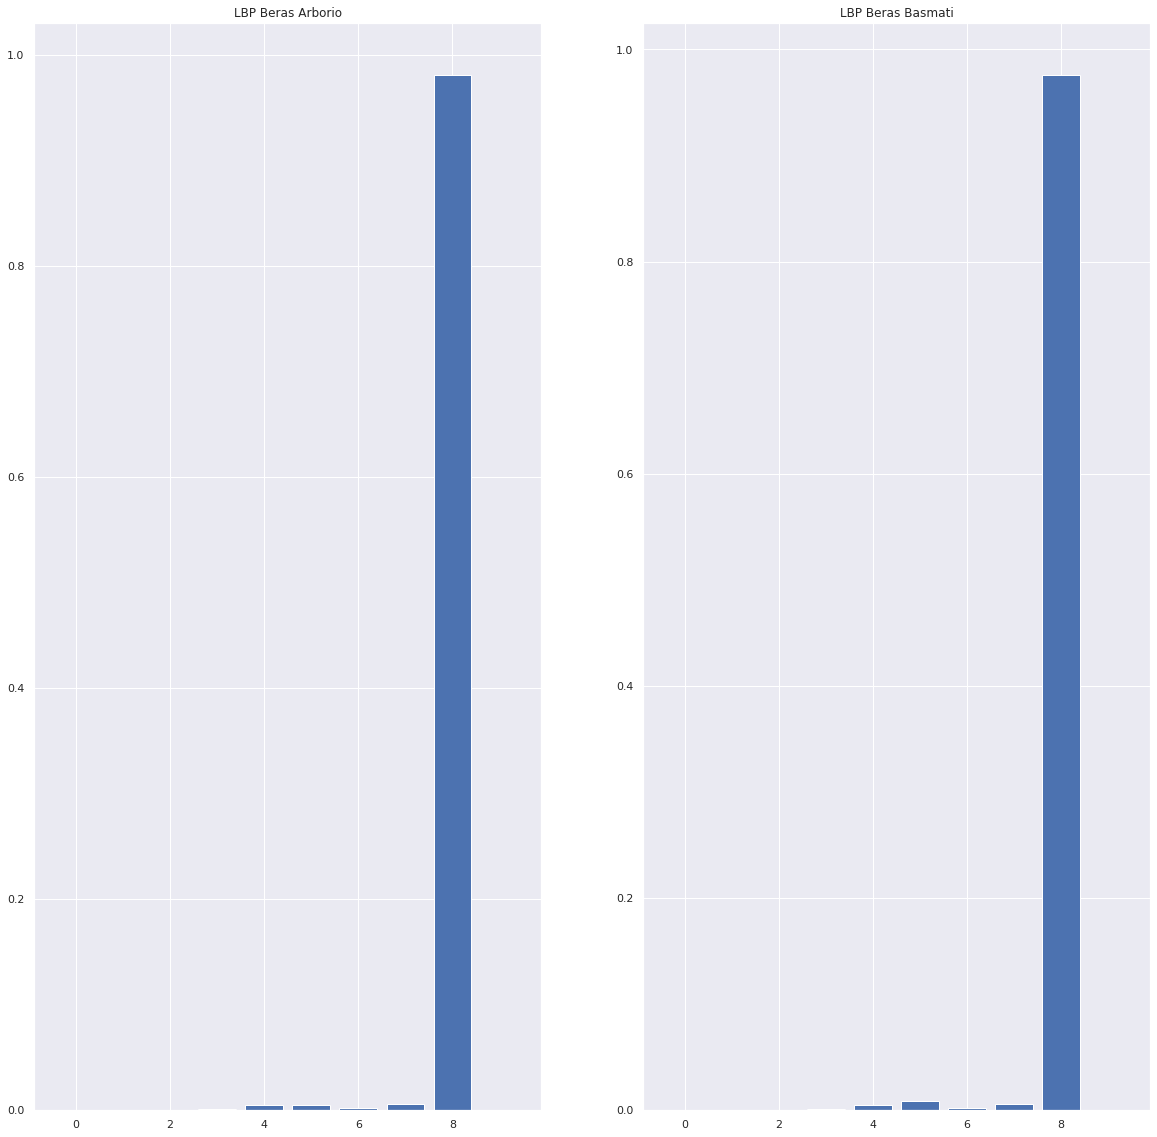

In [ ]:
lbp_data = [lbp0, lbp1]
height = range(len(lbp0))
teks_data = ["LBP Beras Arborio", "LBP Beras Basmati"]

figure = plt.figure(figsize = (20, 20))
next = 1

for i in range(0, len(citra_data)):
    tampilan = figure.add_subplot(1, 2, next)
    tampilan.bar(height, lbp_data[i])
    tampilan.title.set_text(teks_data[i])
    next += 1

plt.show()

# SPLIT DATA

In [31]:
dataset = pd.read_csv('data_projek_pcd.csv')

In [32]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report

In [33]:
X = dataset.iloc[:,:-1].copy()
Y = dataset[['label']].copy()

In [34]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
score_SVM = []
kF = StratifiedKFold(n_splits = 5)
n = 1
clf_SVM = SVC(kernel = 'linear', C = 1000, gamma = 1.0, decision_function_shape = 'ovr', class_weight = 'balanced')

print('Fold Ke : \n')

for train_indeks, test_indeks in kF.split(X,Y):
  X_train, X_test = X.iloc[train_indeks], X.iloc[test_indeks]
  Y_train, Y_test = Y.iloc[train_indeks], Y.iloc[test_indeks]

  Y_train, Y_test = Y_train.values.ravel(), Y_test.values.ravel()

  clf_SVM.fit(X_train, Y_train)
  y_pred = clf_SVM.predict(X_test)
  score_SVM.append(accuracy_score(Y_test, y_pred))
  print(f"{n}. Akurasi Skor Yang Didapat : {accuracy_score(Y_test, y_pred)}")
  n+=1


print(f"Rata-Rata Akurasi : {np.mean(score_SVM)}")

Fold Ke : 

1. Akurasi Skor Yang Didapat : 0.965
2. Akurasi Skor Yang Didapat : 0.9625
3. Akurasi Skor Yang Didapat : 0.9575
4. Akurasi Skor Yang Didapat : 0.9775
5. Akurasi Skor Yang Didapat : 0.96
Rata-Rata Akurasi : 0.9644999999999999


In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y, random_state = 42)

In [36]:
modelSVM = SVC(kernel = 'linear', C = 1000, gamma = 1.0, decision_function_shape = 'ovo', class_weight = 'balanced')

modelSVM.fit(X_train, y_train.values.ravel())

y_pred_svm = modelSVM.predict(X_test)

In [37]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(f'Accuracy Score : {accuracy_score(y_test, y_pred_svm)}')

print('Precission Score : ', precision_score(y_test, y_pred_svm))

print('Recall Score : ', precision_score(y_test, y_pred_svm))

print('F1 Score : ', precision_score(y_test, y_pred_svm))

Accuracy Score : 0.9675
Precission Score :  0.9947089947089947
Recall Score :  0.9947089947089947
F1 Score :  0.9947089947089947


In [38]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97       200
           1       0.99      0.94      0.97       200

    accuracy                           0.97       400
   macro avg       0.97      0.97      0.97       400
weighted avg       0.97      0.97      0.97       400



Text(69.0, 0.5, 'Class Asli')

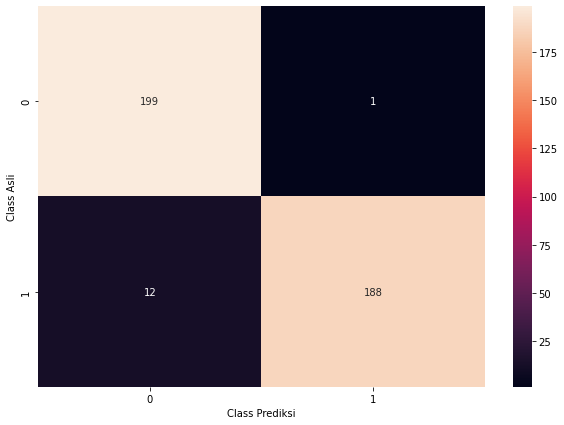

In [39]:
import seaborn as sns
import tensorflow as tf

cm = tf.math.confusion_matrix(labels=y_test,predictions=y_pred_svm)

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Class Prediksi')
plt.ylabel('Class Asli')

In [40]:
dataset = pd.read_csv('data_projek_pcd.csv')